In [22]:
import collections
import math
import string
import numpy as np
import pandas as pd
from itertools import permutations
from sympy.utilities.iterables import partitions
import matplotlib.pyplot as plt 
%matplotlib notebook
#pd.set_option('precision', 7)

**Test Variables**

In [12]:
## Number of unique diseases possible
k = 3

## Priors
pi = [1/2, 1/3, 1/6]
pi_uni = [1/3, 1/3, 1/3]

## Integer Partitions
### n = 6
pa = {3:1, 2:1, 1:1}
pb = {3:2}
pc = {6:1}
pd = {4:1, 1:2}

### n = 4
pe = {3:1, 1:1}

### n <= 3
pf = {2:1}

prior_test = pi
partition_test = pa

**k_dictionary**

Input: pi, the probability distribution

Output: a dictionary with letters for keys. The letters represent individual diseases. Can be used to keep track of individual diseases throughout the gain function calculations.

```python
pi = [1/2, 1/3, 1/6]
k_dict = {'a': 0.5, 'b': 0.33333, 'c':0.166666}
```

In [3]:
def k_dictionary(pi):
    return dict(zip(string.ascii_lowercase, pi))

In [15]:
my_pi_dict = k_dictionary(prior_test)

print(my_pi_dict)

{'a': 0.5, 'b': 0.3333333333333333, 'c': 0.16666666666666666}


---
**list_all_ints** is a helper function to type_probability

Input: the integer partition dictionary

Output: a list of the integers

```python
p = {3:1, 1:2}
col_names = [3, 1, 1]
```

In [5]:
def list_all_ints(p):
    col_names = []
    for i in p.keys(): # i = integer, m = multiplicity
        m = p[i]
        for x in range(m):
            col_names.append(i)
    return col_names

---
**type_3** calculates all possible probabilies for each column type, given an integer partition

Input: 
- an integer partition p 
- pi_dict, a dictionary of diseases and probabilities in k 
- k, the number of unique plaintext values/diseases

```python
p = {6:1}
pi_dict = {'a': 0.5, 'b': 0.33333, 'c':0.166666}
k = 3
```

Output:
- df: columns represent the different blocks. Each row has a different permutation of diseases. The final column is the probability of that particular column type occuring
- int_list: the expanded form of the integer partition

Notes: 
- hardcoded for k = 3
- uses list_all_ints(p) as a helper function. 

In [23]:
def type_3(p, pi_dict, k):
    int_list = list_all_ints(p)
    int_list_len = len(int_list)
    data = list(permutations(pi_dict.keys(), min(k, int_list_len)))
    df = pd.DataFrame(data = data, columns=int_list)
    if int_list_len == 1:
        df['prob']= pow(df.iloc[:,0].map(pi_dict), df.columns.values[0])
    elif int_list_len == 2:
        df['prob']= pow(df.iloc[:,0].map(pi_dict), df.columns.values[0]) * pow(df.iloc[:,1].map(pi_dict), df.columns.values[1])
    elif int_list_len == 3:
        df['prob']= pow(df.iloc[:,0].map(pi_dict), df.columns.values[0]) * pow(df.iloc[:,1].map(pi_dict), df.columns.values[1]) * pow(df.iloc[:,2].map(pi_dict), df.columns.values[2])
    else:
         raise ValueError("The integer partition doesn't make sense")
    return df, int_list

In [24]:
my_df, my_int_list = type_3(partition_test, my_pi_dict, k)
my_df

,3,2,1,prob
0,a,b,c,0.002315
1,a,c,b,0.001157
2,b,a,c,0.001543
3,b,c,a,0.000514
4,c,a,b,0.000386
5,c,b,a,0.000257


---
***choices_matrix()*** provides a matrix listing all the choices for a given integer partition and prior pi

Input:
- df: the dataframe with all possible types for the integer partition
- int_list: the expanded integer partition

Output:
- df_g, or dataframe_guess, a matrix with the (not normalized) probabilities of every possible block in the integer partition being a particular disease.


In [25]:
def choices_matrix(df, int_list):
    df_g = pd.DataFrame(0, index=int_list, columns=['a','b','c'])
    col = 0
    for i in int_list:
        df_g.loc[i,'a'] = df[df.iloc[:,col] == 'a']['prob'].sum()
        df_g.loc[i,'b'] = df[df.iloc[:,col] == 'b']['prob'].sum()
        df_g.loc[i,'c'] = df[df.iloc[:,col] == 'c']['prob'].sum()
        col = col + 1
    return df_g

In [26]:
# Test of choices_matrix() w/type 4
my_df_guess = choices_matrix(my_df, my_int_list)
my_df_guess

,a,b,c
3,0.003472,0.002058,0.000643
2,0.001929,0.002572,0.001672
1,0.000772,0.001543,0.003858


---
***reduce_choices()*** reduces the size of the df_g matrix by removing equal choices

Input:
- df_g, the matrix containing all of the possible choices
- p, the integer partition dictionary

Output:
- df_reduced_guess, a dataframe that indicates the possible unique choices an adversary choice make given an integer partition

In [27]:
def reduce_choices(df_g, p):
    data = []
    # if p[k] (multiplicity) >1, only take one row
    for k in p.keys(): # for every unique integer in p, copy a row in df_guess that matches the int
        if p[k] > 1: # choose first example if >1
            data.append(df_g.loc[k].iloc[0])
        else:
            data.append(df_g.loc[k]) #copy the row
    df_reduced_guess = pd.DataFrame(data = data)
    return df_reduced_guess

In [28]:
my_reduced_df = reduce_choices(my_df_guess, partition_test)
my_reduced_df.head()

,a,b,c
3,0.003472,0.002058,0.000643
2,0.001929,0.002572,0.001672
1,0.000772,0.001543,0.003858


In [50]:
def no_choice_max(df_g, num_index, pi):
    total = -1
    df_col_max = df_g.max(axis=1)
    vec = [x * num_index for x in pi]
    total = df_col_max.mul(vec).sum(axis=0)
    return total

In [51]:
my_num_index = 60
total = no_choice_max(my_df_guess, my_num_index, prior_test)
print(total)

0.19418724279835387


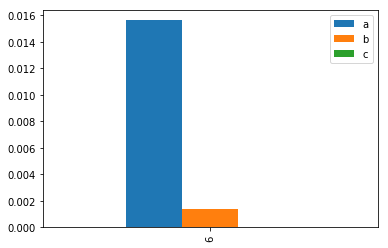

In [26]:
my_reduced_df.plot.bar()

---
***choose_max()*** takes the reduced matrix and says which guess to make, along with the posterior vulnerability the integer partition provided

Input:
- df_reduced_guess, the reduced matrix of choices

Output:
- val, the contribution to the posterior vulnerability for one instance of one integer partition
- block_size, the block to guess about
- disease, the correct disease, or plaintext value, to guess

In [12]:
def choose_max(df_reduced_guess):
    col_max_values = df_reduced_guess.max() # per column, the max values
    col_max_values_id = df_reduced_guess.idxmax() # per column (disease), the index/block size of the max values
    val = col_max_values.max() # max of the column maximums
    disease = col_max_values.idxmax() # disease (column) of the above value
    block_size = col_max_values_id.loc[disease] # contribution to the posterior vuln by this integer partition
    return val, block_size, disease

In [13]:
# Tets of choose_max
my_val, my_block, my_disease = choose_max(my_reduced_df)
print("contribution of partition to posterior vuln: ", my_val)
print("*********The best choice is*********")
print("block size: ", my_block)
print("disease: ", my_disease)

contribution of partition to posterior vuln:  0.02469135802469135
*********The best choice is*********
block size:  3
disease:  a


---
**calc_index_partitions()** calculates number of index partitions given an integer n and a integer partition p

Input:
- n: positive integer, the size of the column
- p: a unique integer partition, as a python dictionary

Output:
- frac: the number of index partitions that can have integer partition p

Generalized formula:<br>
With an interger partition $p$ containing integers $i$, each with multiplicity of $m$,
$$\text{index partitions}(n,p)=\frac{n!}{\prod_{i \in p} i!^m m!}$$

Example:<br>
$$\text{index partitions}(6,\{4:1, 1:2\}) = \frac{6!}{\left(4!\right)1! \times \left(1!\right)^2 2!} $$

In [ ]:
def calc_index_partitions(n,p):
    num = math.factorial(n)
    den = 1
    mul = 0
    for i in p.keys():
        mul = p[i]
        den = den * pow(math.factorial(i), mul) * math.factorial(mul)
    num_index = num / den
    return num_index

---
**post_vuln()** calculates the posterior gain vulnerability

Input:
- n: the size of the column (number of patients)
- k: the number of plaintext values (diseases)
- pi: the probability distrubution of the values in k

Output:
- pgvsum: the posterior gain vulnerability for that n value
- post_vuln_df returns choices_df: a dataframe where every row represents a different integer partition and contains the number of index partitions given the integer partition, the correct block and disease guess, the per integer partition contribution to the posterior gain vulnerability, and the weighted contribution to the posterior gain vulnerability (by the number of index partitions)

Notes:
- Due to the helper functions, this is hardcoded for k = 3

The following image displays functions or operations as rectangles and variables as ovals. The light purple background indicates the integer partition loop.
![alt text](choose_flow.png "Flow of Post_vuln")

In [15]:
def post_vuln(n, k, pi): #does not return a dataframe w/every partition
    pgvsum = 0
    pi_dict = k_dictionary(pi) # the dictionary of diseases and probabilies {a:1/2, b:1/3, etc.}
    for p in partitions(n, m=k): 
        num_index = calc_index_partitions(n,p) # p's number of index partitions
        df, int_list = type_3(p, pi_dict, k) # the probabilities of different types of the column
        df_g = choices_matrix(df, int_list) # the disease:block size guesses the adversary can make
        df_reduced = reduce_choices(df_g, p) # reduced dataframe, no 0s or duplicates
        contribution, block_size, disease = choose_max(df_reduced)#posterior vuln for 1 p and best guess
        weighted = num_index * contribution
        pgvsum = pgvsum + weighted
    return pgvsum

In [16]:
def post_vuln_df(n, k, pi):
    pgvsum = 0
    pi_dict = k_dictionary(pi)
    data = []
    for p in partitions(n, m=k): 
        p_guess = {}
        num_index = calc_index_partitions(n,p) # p's number of index partitions
        df, int_list = type_3(p, pi_dict, k) # the probabilities of different types of the column
        df_g = choices_matrix(df, int_list) # the disease:block size guesses the adversary can make
        df_reduced = reduce_choices(df_g, p) # reduced dataframe, no 0s or duplicates
        contribution, block_size, disease = choose_max(df_reduced)#posterior vuln for 1 p and best guess
        weighted = num_index * contribution
        pgvsum = pgvsum + weighted
        p_guess = {'partition': int_list, 'contribution': contribution, 'indexes': num_index_partitions, 'block_size': block_size, 'disease': disease, 'weighted': weighted}
        data.append(p_guess)
    choices_df = pd.DataFrame(data = data)
    return pgvsum, choices_df

In [17]:
n = 12
print("posterior gain vulnerability for n = %s " % n)
post, choices_df = post_vuln_df(n, k, pi)
print(post)

posterior gain vulnerability for n = 12 
0.8127857796067669


In [23]:
n = 4
print("posterior gain vulnerability for n = %s " % n)
post, choices_df = post_vuln_df(n, k, [1/3, 1/3, 1/3])
print(post)

posterior gain vulnerability for n = 4 
0.33333333333333326


In [24]:
choices_df

,block_size,contribution,disease,indexes,partition,weighted
0,4,0.012346,a,1.0,[4],0.012346
1,3,0.024691,a,4.0,"[3, 1]",0.098765
2,2,0.024691,a,3.0,"[2, 2]",0.074074
3,2,0.024691,a,6.0,"[2, 1, 1]",0.148148


### Graphs

In [44]:
def color_plot_vuln(df):
    fig, ax = plt.subplots() # to show xtick labels
    df.reset_index().plot.scatter(x='index', 
                y='weighted',
                c = 'contribution', # the color map scale
                colormap='winter_r',
                ax = ax)
    plt.xticks(df.index, df['partition'], rotation=90)
    plt.title("Individual and Weighted Vulnerability Per Integer Partition")
    plt.show()
##Graph options w/o colormap
#choices_df.plot(x='partition', 
#                y='weighted',
#                style='o-')
#plt.xticks(choices_df.index, choices_df['partition'], rotation=90)
#plt.show()

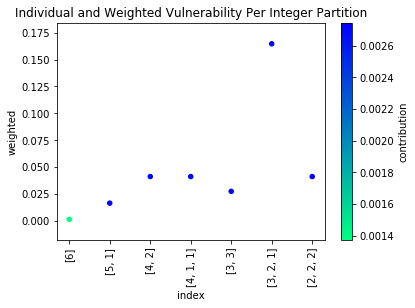

In [45]:
color_plot_vuln(choices_df)

In [25]:
def graph_it_prior_post(n_range, k, probs, df):
    x = [i+1 for i in range(n_range)]
    y_posterior = df["posterior"].iloc[-1] # saves last posterior y
    
    plt.plot(x, 'prior', 
             data=df, 
             linestyle='--', 
             label="prior")
    plt.plot(x, 'posterior', 
             data=df, 
             marker='', 
             label="posterior")
    plt.xlabel('n values')
    plt.ylabel('gain vulnerability')
    plt.ylim(bottom=0, top = 1)
    
     # orange dot for last y posterior vulnerability
    plt.annotate('%.3f' % y_posterior, 
                 xy=[n_range, y_posterior],
                 xytext=(-20, -15),
                 textcoords='offset points')
    plt.plot(n_range, y_posterior, 
             marker = 'o', 
             markerfacecolor='orange',
             markeredgecolor='orange')
    
    # title rounds the prior
    format_probs = ['%.3f' % prob for prob in probs]
    plt.title(f'k = {k}, prior = {format_probs}')
    
    plt.show()

In [20]:
def graph_prior_post(n_range, k, probs):
    post_vs = []
    prior_vs = []
    probs.sort(reverse=True) 
    prior_val=probs[0] # sets the line for prior vuln
    for i in range(n_range):
        post_vs.append(post_vuln(i+1, k, probs))
        prior_vs.append(prior_val)
    df = pd.DataFrame(
        {'prior':prior_vs,
         'posterior':post_vs
        }
    )
    graph_it_prior_post(n_range, k, probs, df)

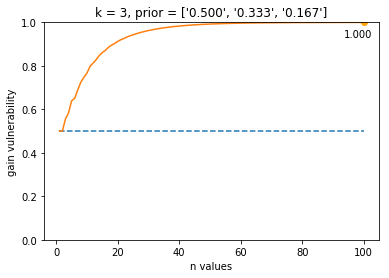

In [26]:
graph_prior_post(100, 3, [1/2, 1/3, 1/6])

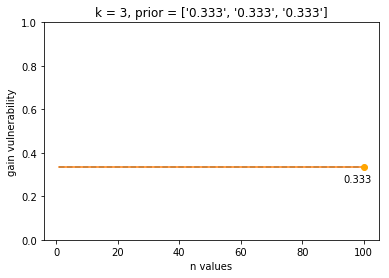

In [27]:
graph_prior_post(100, 3, [1/3, 1/3, 1/3])

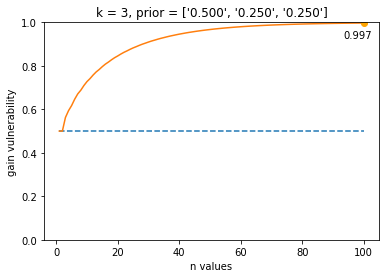

In [28]:
graph_prior_post(100, 3, [1/2, 1/4, 1/4])

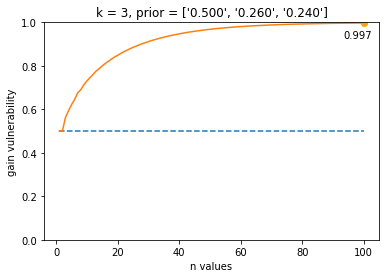

In [29]:
graph_prior_post(100, 3, [1/2, .24, .26])

### Old Functions

Output: 
- df, a dataframe. The first three columns are 'a', 'b', and 'c', the diseases.  The final column is the probability of the column's type. The rows represent the type of column.
- int_list, a expanded list of the integer partition. For example, if p = {3:2}, int_list = [3, 3]

An example of df:

|   -  | a | b | c | probs |
|---|--|---|---|-------|
| 0   | 6 | 0 | 0 | 0.0156250 |
| 1   | 0 | 0 | 6 | 0.0000214 |
| 2   | 0 | 6 | 0 | 0.0013717 |


In [ ]:
def old_type_3(p, pi, k):
    int_list = list_all_ints(p)
    int_list.extend([0] * (k-len(int_list))) # pads list with 0s
    data = list(permutations(int_list, k))
    df = pd.DataFrame(data = data, columns=['a', 'b','c'])
    df['prob'] = pow(pi[0], df['a']) * pow(pi[1], df['b']) * pow(pi[2], df['c'])
    return df, int_list

In [ ]:
def old_choices_matrix(df, int_list):
    df_g = pd.DataFrame(0, index=int_list, columns=['a','b','c'])
    for i in int_list:
        df_g.loc[i,'a'] = df[df['a'] == i]['prob'].sum()
        df_g.loc[i,'b'] = df[df['b'] == i]['prob'].sum()
        df_g.loc[i,'c'] = df[df['c'] == i]['prob'].sum()
    return df_g